# Study of "TikTok Refugee's" Content Adaptation on Xiaohongshu

## 1. Introduction

### 1.1 Background  
In January 2025, the United States government intensified its scrutiny of TikTok, citing national security concerns related to its Chinese ownership by ByteDance. This led to significant uncertainty regarding the platform’s availability (Wall Street Journal, 2025). In response, waves of American users flooded into Xiaohongshu（a Chinese social media platform integrating e-commerce, short videos, and lifestyle content）, as if they had discovered a "social media refuge." This sudden migration sparked discussions within Chinese online communities, with users expressing curiosity about the influx of foreign participants (21st Century Business Herald, 2025).Someones exclaimed, **"Has Xiaohongshu become a shelter for TikTok refugees?"** Others marveled, "Is this the birth of an international community?" But as the policy shifted in February, the frenzy vanished overnight. This sudden migration of TikTok users to Xiaohongshu raises an important question: 

**Is this user shift temporary, or does it indicate a lasting trend?**

This project examines whether these users retain their TikTok interaction styles or adapt to Xiaohongshu’s platform norms. By analyzing their behavior and textual content, I identify **three key adaptation strategies**:

1. **Content Imitation** – Users replicate TikTok-style posts and engagement behaviors.
2. **Community Integration** – Users adopt Xiaohongshu’s social engagement model.
3. **Cultural Adaptation** – Users engage in discussions comparing TikTok and Xiaohongshu norms.

### 1.2 Research Objectives
This study seeks to answer the following key questions:
- Do TikTok refugees exhibit significant behavioral changes after migrating to Xiaohongshu?
- Do they maintain a TikTok-oriented content style, or do they gradually transition to Xiaohongshu norms?
- What are the core factors influencing user adaptation?
- How do interaction behaviors affect user retention on Xiaohongshu?
- What topics are primarily discussed by migrated users? Which topics contribute to long-term retention?
- Are there anomalous users (e.g., bot accounts or highly active influencers)?
- Do different types of TikTok migrants exhibit distinct preferences for Xiaohongshu’s recommendation algorithm?

This research employs **unsupervised learning methods** (K-Means clustering, NMF topic modeling, DBSCAN anomaly detection) to quantitatively identify user groups, analyze adaptation pathways, and explore strategies for optimizing platform operations.

### 1.3 Business Value
This study provides **data-driven insights** to optimize TikTok refugee retention and platform engagement through:
- **Providing Quantitative Analysis** – Analyzing real data on TikTok refugees' adaptation to Xiaohongshu.
- **Optimizing Platform Strategies** – Proposing data-driven personalized recommendations and user engagement strategies.
- **Identifying High-Value Users** – Discovering cross-platform creators to enhance community development.
- **Enhancing Platform Security** – Using anomaly detection to identify potential bot accounts or marketing accounts.
- **Community Growth & Influencer Development** – Identifying cross-platform creators and supporting their integration.

---
This project will carry out a solution with **unsupervised learning techniques** including clustering(K-Means + NMF topic modeling) and anomaly detection (DBSCAN), to categorize user types and analyze their adaptation success.


In [366]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import jieba

from datetime import datetime
from transformers import BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## 2. Exploratory Data Analysis (EDA)

### 2.1 Dataset Overview
The dataset includes Xiaohongshu posts from **January 1, 2025, to February 28, 2025**, containing:
- **User behavioral features** (likes, comments, shares, saves).
- **Time-based features** (post time, posting frequency, active hours).
- **Textual features** (titles, content, keyword extraction).
- **Category features** (content type, e.g., video/image).

In [375]:
# Load the data (ensure the file path is correct)
file_path = 'tt refugee content.csv'
df = pd.read_csv(file_path)

# Display dataset info
print("Dataset Overview:")
df.info()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          572 non-null    object
 1   content        700 non-null    object
 2   address        724 non-null    object
 3   label          608 non-null    object
 4   user_name      724 non-null    object
 5   user_id        724 non-null    object
 6   like_count     724 non-null    object
 7   collect_count  724 non-null    object
 8   comment_count  724 non-null    object
 9   share_count    724 non-null    object
 10  create_time    724 non-null    object
 11  post_id        724 non-null    object
 12  ip_localtion   724 non-null    object
 13  post_image     724 non-null    object
 14  post_type      724 non-null    object
dtypes: object(15)
memory usage: 85.0+ KB


### 2.2 Data Preprocessing
- **Text Data Cleaning** (removing special characters, handling mixed Chinese-English text).
- **Numeric Conversion** (converting '10K+' format to integers).
- **Time Feature Extraction** (formatting timestamps, extracting posting hours).

Code implementation is provided below.

In [378]:
# Text Cleaning with Jieba
def clean_text(text):
    cleaned = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9\s，。！？]', '', str(text))
    return cleaned.strip()

def tokenize(text):
    return ' '.join(jieba.cut(text))

df['title'] = df['title'].apply(clean_text).apply(tokenize)
df['content'] = df['content'].apply(clean_text).apply(tokenize)
df['text'] = df['title'] + ' ' + df['content']

# Convert numeric fields
def convert_count(value):
    if pd.isna(value) or value == '':
        return 0
    value = str(value).replace('+', '')
    if '万' in value:
        num = float(re.sub(r'[^\d.]', '', value)) * 10000
        return int(num)
    else:
        return int(re.sub(r'[^\d]', '', value))

numeric_cols = ['collect_count', 'comment_count', 'share_count', 'like_count']
for col in numeric_cols:
    df[col] = df[col].apply(convert_count)

df['create_time'] = pd.to_datetime(df['create_time'], errors='coerce')
df['post_hour'] = df['create_time'].dt.hour

df.fillna(0, inplace=True)

# fliter useless columns
keep_cols = [
    'user_id', 'title', 'content', 'text', 'create_time', 'post_hour',
    'collect_count', 'comment_count', 'share_count', 'like_count', 'post_type'
]
df = df[keep_cols]

display(df.head())

,user_id,title,content,text,create_time,post_hour,collect_count,comment_count,share_count,like_count,post_type
0,6784c212000000000801d9d3,tiktok refugee indie artist,everyone has been so kind and welc...,tiktok refugee indie artist everyone h...,2025-01-14 12:08:00,12,3829,5851,2509,76000,video
1,67854108000000000801ec77,Tiktok refugee,,Tiktok refugee,2025-01-14 02:36:00,2,4148,3398,3480,71000,video
2,6783e106000000000801f7b8,我会 留下来,小红书 话题 抖音 话题 美国 人 话题 抖音 难民 话题,我会 留下来 小红书 话题 抖音 话题 美国 人 话题 抖音 难民 话题,2025-02-24 16:23:00,16,793,1677,24,61000,video
3,6784876f000000000801e1d9,TikTok refugee,The fact people would literally use ...,TikTok refugee The fact people would ...,2025-01-13 11:47:00,11,2307,17000,14000,55000,video
4,6784c212000000000801d9d3,tiktok refugee and artist,True Love by Emmanuel Zamar please...,tiktok refugee and artist True Love ...,2025-01-13 19:41:00,19,1667,4481,1355,47000,video


### 2.3 Data Visualization
- **User Behavioral Feature Distribution** (histograms, box plots).
- **Text Keyword Analysis** (TF-IDF extraction of high-frequency words).
- **Time Trend Analysis** (distribution of active posting times).

Code implementation is provided below.

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

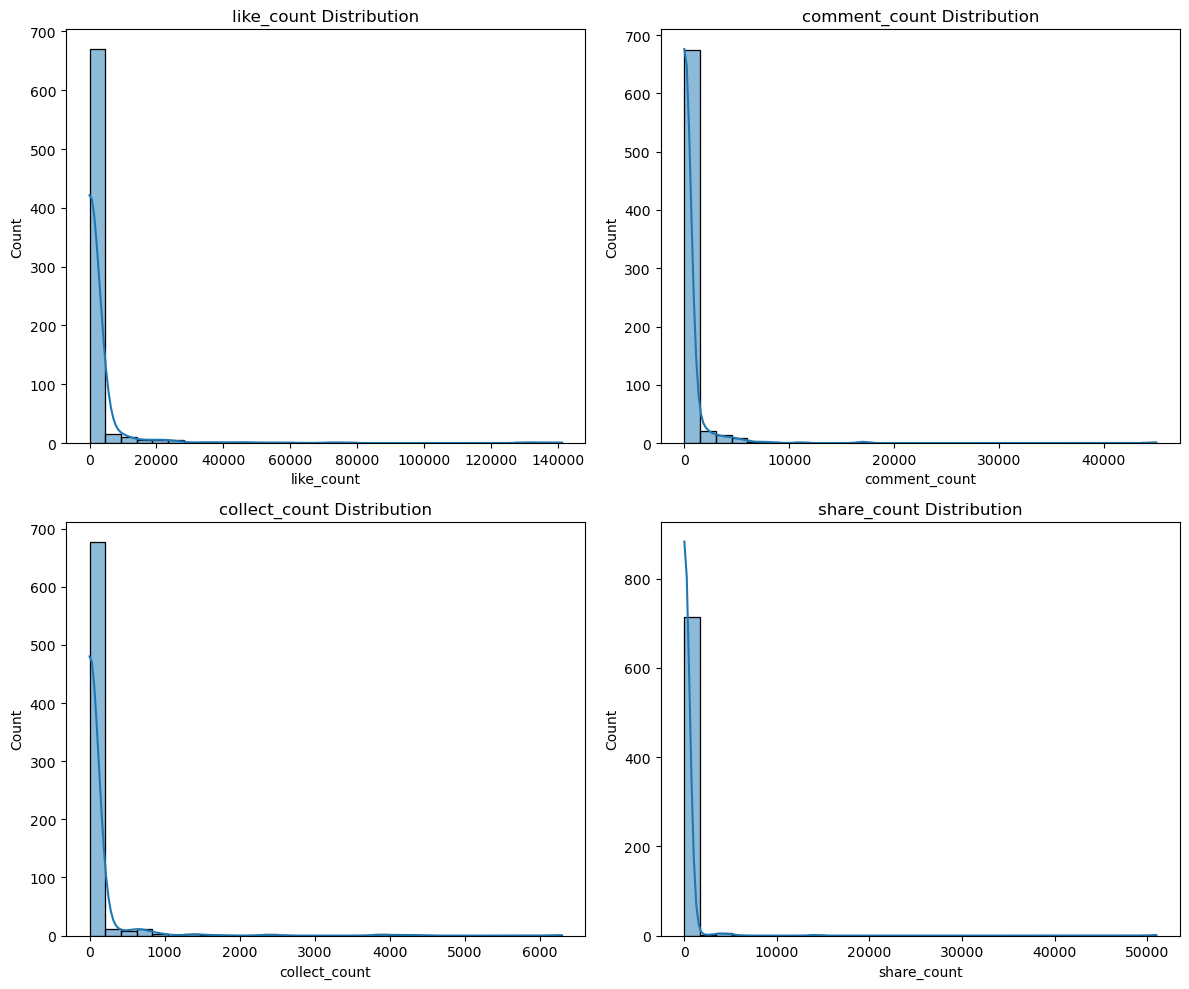

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


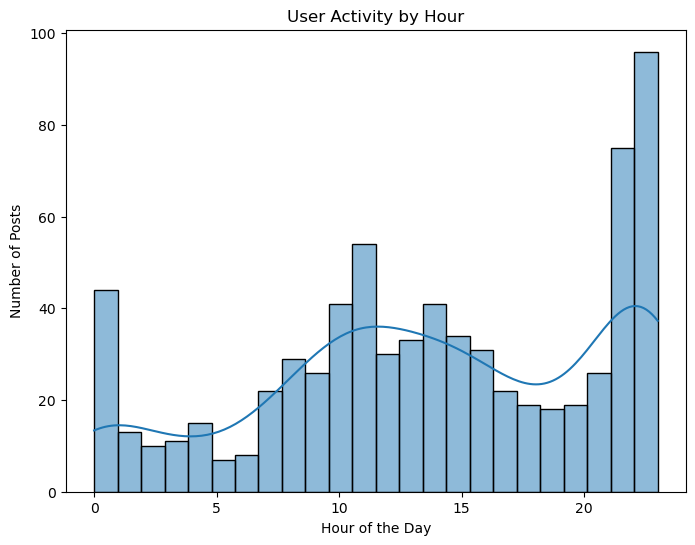

In [341]:
# Data Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
features = ['like_count', 'comment_count', 'collect_count', 'share_count']
for i, feature in enumerate(features):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{feature} Distribution')
plt.tight_layout()
plt.show()

# User Activity by Hour
plt.figure(figsize=(8,6))
sns.histplot(df['post_hour'], bins=24, kde=True)
plt.title('User Activity by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Posts')
plt.show()

## 3. Unsupervised Learning Models
### 3.1 Keyword Extraction (TF-IDF)

In [415]:
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text'])

# NMF Topic Modeling
n_topics = 3
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_features = nmf_model.fit_transform(tfidf_matrix)

# Display top words for each topic
feature_names = tfidf.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: tiktok, refugee, im, hi, hello, just, new, refugees, friends, love
Topic 1: 话题, tiktokrefugee, tiktokrefugees, 难民, 美国, american, fyp, 抖音, 中国, america
Topic 2: nan, hello, im, just, follow, hi, ask, 朋友, friends, english


#### Key Findings
 
Through TF-IDF keyword extraction, I found that TikTok refugees on Xiaohongshu mainly focus on:

1. **TikTok-related topics**: "tiktok", "refugee", "tiktokrefugees话题", "tiktok话题", "抖音难民话题"
    - Many users still strongly identify as TikTok refugees.
2. **Social interaction**: "friends", "follow", "community", "welcome", "你好"
    - Some users seek to establish social connections on Xiaohongshu and find new friends.
3. **Cross-cultural adaptation**: "american话题", "usa", "chinese", "learn"
    - Some users are discussing **cultural differences between the U.S. and China**, comparing TikTok and Xiaohongshu.

### 3.2 User-behaviour Clustering (K-Means + NMF Topic Modeling)
- **K-Means Clustering** – Grouping users based on behavioral data.
- **NMF Topic Modeling** – Extracting latent topics from text data to analyze content interests.
- **Combining Clustering & Topic Modeling** to identify adaptation strategies among TikTok migrants.


Using **K-Means clustering**, we grouped users based on **behavioral features** and **text topic distribution**, resulting in **three user segments**:

| **User Type** | **Behavioral Features** | **Text Content** | **Adaptation Strategy** |
|-------------|-------------|-------------|----------------|
| Cluster 0: Mainstream Migrants (Majority Users) | High posting frequency, moderate engagement | TikTok migration identity + social engagement | Gradually adapting to Xiaohongshu but still retaining TikTok habits |
| Cluster 1: Social Explorers (Low Engagement Users) | Low engagement, mostly focused on social mechanisms | Still following TikTok habits, interested in how to gain followers | Still exploring, not fully integrated into Xiaohongshu |
| Cluster 2: Cultural Adapters (Small Cross-Cultural Group) | Moderate engagement but behaviorally distinct from mainstream users | Discussing cultural differences between TikTok and Xiaohongshu | Trying to adapt to Xiaohongshu culture but still influenced by TikTok |

Code implementation is provided below.

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Silhouette Score for K-Means: 0.9587


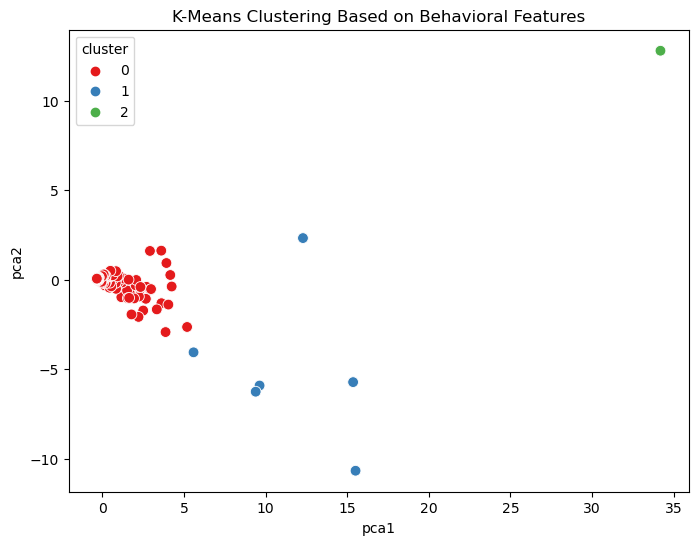

In [450]:
# K-Means Clustering
scaler = StandardScaler()
behavior_scaled = scaler.fit_transform(df[numeric_cols])

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(behavior_scaled)

# Evaluate clustering with Silhouette Score
silhouette_avg = silhouette_score(behavior_scaled, df['cluster'])
print(f'Silhouette Score for K-Means: {silhouette_avg:.4f}')


# PCA for Visualization
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(behavior_scaled)
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='Set1', s=60)
plt.title('K-Means Clustering Based on Behavioral Features')
plt.show()


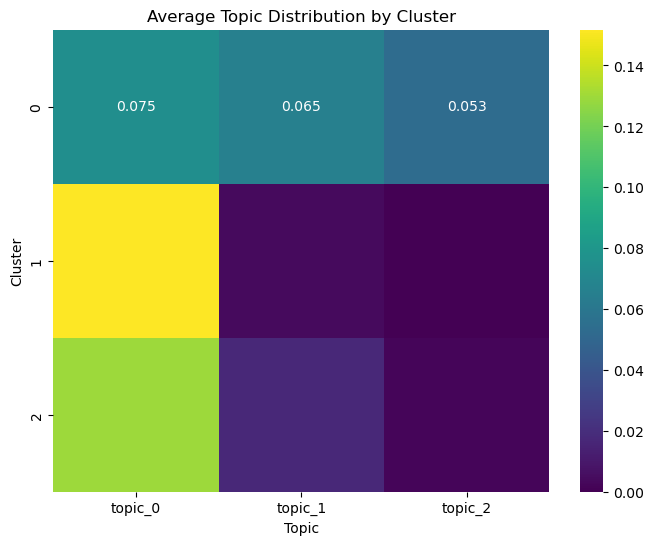

In [458]:
# NMF cross analysis
for i in range(n_topics):
    df[f'topic_{i}'] = nmf_features[:, i]

# Calculate the average topic distribution for each cluster
cluster_topic_mean = df.groupby('cluster')[[f'topic_{i}' for i in range(n_topics)]].mean()

# heatmap for Visualization
plt.figure(figsize=(8,6))
sns.heatmap(cluster_topic_mean, annot=True, cmap='viridis')
plt.title('Average Topic Distribution by Cluster')
plt.xlabel('Topic')
plt.ylabel('Cluster')
plt.show()

#### Key Oservations
- **Most users (Cluster 0) are gradually adapting to RedNote** but still carry a TikTok refugee identity.  
- **Some users (Cluster 1) continue their TikTok habits with little interaction**, making it harder for them to integrate.  
- **A smaller group (Cluster 2) focuses on cultural adaptation**, potentially high-value future creators.  


### 3.3 Anomaly Detection with DBSCAN

Using **DBSCAN**, I identified anomalous users, with the following results:

- **Cluster 0 (Main User Group)** 
- **Cluster -1 (Scattered Outliers)**

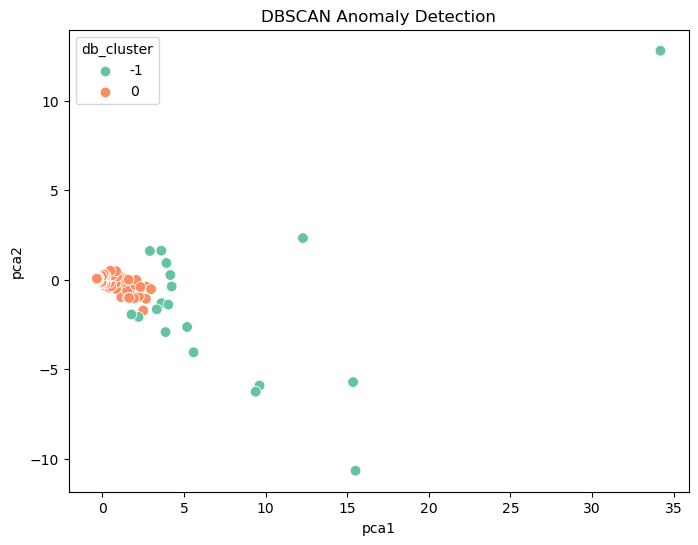

,user_id,cluster,db_cluster
0,6784c212000000000801d9d3,1,-1
1,67854108000000000801ec77,1,-1
2,6783e106000000000801f7b8,0,-1
3,6784876f000000000801e1d9,1,-1
4,6784c212000000000801d9d3,0,-1


In [462]:
# DBSCAN Anomaly Detection
dbscan = DBSCAN(eps=1.0, min_samples=10)
df['db_cluster'] = dbscan.fit_predict(behavior_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x='pca1', y='pca2', hue='db_cluster', data=df, palette='Set2', s=60)
plt.title('DBSCAN Anomaly Detection')
plt.show()

# Conclusion
display(df[['user_id', 'cluster', 'db_cluster']].head())

#### Key Observations
Now we may find that:

- **Cluster 0 (Main User Group)**: Most users are clustered around [0,0] to [5,0], considered normal users.
- **Cluster -1 (Scattered Outliers)**: A smaller group of users with behavior patterns that differ significantly from mainstream users.


#### Possible Types of Anomalous Users
1. **Extremely Active Users (KOLs / Influencers)**
   - These users have **significantly higher engagement (likes, comments, shares)** than the average.
   - They may be **new influential creators** on Xiaohongshu.

2. **Marketing Accounts / Bots**
   - Examples:
     - **High likes/comments but no posts** → Potential bot account.
     - **Mass posting in a short period with no engagement** → Potential spam account.

3. **Silent Users**
   - These users have **low engagement**, rarely interact, and are mostly passive observers.

- **Next Steps**
    - Identify highly active users and provide incentives to retain them.
    - Detect and restrict marketing accounts to prevent spam.
    - Personalize content recommendations to increase engagement among silent users.
    
---

## 4. Business Recommendations
Based on the findings, we propose the following **operational strategies**:

### 4.1 For TikTok Migrants (Cluster 0, Mainstream Users)
1. **Help them adapt to Xiaohongshu’s ecosystem**  
- **Recommend more localized content** (product reviews, lifestyle vlogs) to ease the transition.  
- **Introduce "TikTok to Xiaohongshu" guides** to simplify content creation and improve retention.  

2. **Encourage interaction and increase engagement**  
- Boost **exposure for users with high posting frequency but low engagement**, encouraging them to interact more.  
- Introduce **comment-based challenges and engagement incentives** to enhance participation.  



### 4.2 For Social Explorers (Cluster 1)
1. **Facilitate better community integration**  
- **Launch "Social Features 101" guides** to teach them how to engage and gain followers.  
- **Improve newcomer recommendation algorithms** to help them find relevant connections faster.  

2. **Increase engagement incentives**  
- **Introduce "New User Engagement Rewards"** (e.g., comment on three posts to earn points).  
- Prioritize **high-potential users in recommendation algorithms**, helping them gain visibility.  



### 4.3 For Cultural Adapters (Cluster 2)
1. **Support potential KOLs and attract cross-platform users**  
- **Identify and support key influencers in this group**, encouraging them to become opinion leaders.  
- **Encourage content discussing TikTok vs. Xiaohongshu**, helping new users transition smoothly.  

2. **Improve cross-cultural adaptability**  
- Establish a **"Cross-Cultural Discussion Zone"** to encourage dialogue about TikTok vs. Xiaohongshu.  
- Provide more **localized content recommendations** for overseas users to enhance their experience.  

### Conclusion

1. TikTok refugees are gradually adapting to Xiaohongshu but still retain some old habits.
2. Social engagement is key to successful adaptation; low-interaction users are at higher risk of leaving. 
3. Some users are focused on cultural adaptation and could become key opinion leaders. 
4. Targeted support, optimized content recommendations, and engagement incentives can improve retention.

This study provides **data-driven insights for Xiaohongshu’s TikTok refugee user strategy**, helping refine **growth and retention plans**. 

---


## 5. Future Work
### 5.1 Next Steps for Optimization
- Conduct a **user retention analysis** to validate long-term adaptation trends.  
- Further analyze **anomalous users** to optimize risk control strategies.  
- Use **social network analysis** to identify influential users and community structures.  

This comprehensive analysis will help Xiaohongshu **better understand TikTok refugees**, **increase engagement**, and **improve retention strategies**. 🚀  

### 5.2 Future Approaches
This study systematically analyzes the adaptation pathways of TikTok migrants on Xiaohongshu and proposes optimization strategies. Future approach can be:
- **Extend the Time Range** – Analyze long-term user adaptation trends.
- **Develop Prediction Models** – Identify users with high future adaptation potential.
- **Strengthen Social Network Analysis** – Explore the impact of user interactions on adaptation.